# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import sys
import time

## GW150914

Download data

In [84]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

In [3]:
kwarg_dict = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+0.0*1e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**kwarg_dict)

Load data

In [4]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

Perform time alignment across detectors

In [5]:
fit.detector_alignment(**kwarg_dict)

Condition data 

In [6]:
fit.condition_data(**kwarg_dict)

Cholesky-decomposition of the covariance matrix 

In [7]:
fit.compute_acfs()
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [8]:
chispace = np.linspace(0.0, 0.95, 100)
massspace = np.linspace(34, 100, 100)
X, Y = np.meshgrid(massspace, chispace)

Interate over the samplings

In [9]:
tic = time.time()
flatten_array = [(i,j) for i in massspace for j in chispace]

final = Parallel(-1)(delayed(fit.likelihood_vs_mass_spin)(i, j, **kwarg_dict) 
                     for i,j in flatten_array)
    
reshaped_array = np.reshape(final, (len(chispace), len(massspace))).T
toc = time.time()
print((toc-tic)/60)
finalfinal = reshaped_array

0.3117719888687134


In [10]:
np.shape(finalfinal)

(100, 100)

In [11]:
finalfinal_normalised = (finalfinal - finalfinal.min())/(finalfinal.max() - finalfinal.min())
finalfinal_xsum = np.trapz(finalfinal, axis = 0)
finalfinal_ysum = np.trapz(finalfinal, axis = 1)
finalfinal_xhist = finalfinal_xsum/finalfinal_xsum.sum()
finalfinal_yhist = finalfinal_ysum/finalfinal_ysum.sum()

Plot 2d contours

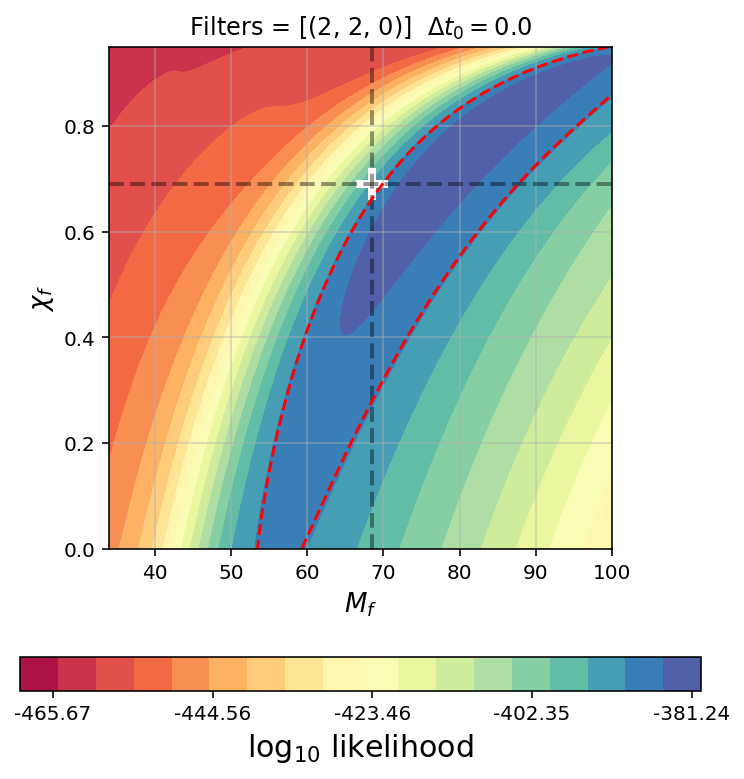

In [12]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(X, Y, finalfinal, 20, cmap='Spectral',
                       origin='lower', alpha=1.0, linestyles='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='white', linewidths=4, label='IMR')
ax.axvline(x=68.5, c='k', ls = '--', alpha = 0.4, linewidth = 2)
ax.axhline(y=0.69, c='k', ls = '--', alpha = 0.4, linewidth = 2)
ax.grid(visible = True, alpha = 0.5)
dotted = ax.contour(X, Y, finalfinal_normalised, [0.9], colors = 'red', \
                   linestyles ='--')

# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\log_{10}$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(finalfinal), np.max(finalfinal), 5))

pl.xlabel(r'$M_f$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
ax.set_box_aspect(1)

ax.set_title(r'Filters = '+ str(kwarg_dict["model_list"]) + '  $\Delta t_0 = $' + str((kwarg_dict["t_init"] - 1126259462.4083147)*1e3));

In [ ]:
# Attempting to recreate the side histograms, doesn't work properly

fig = pl.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1), height_ratios=(1, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

contours = ax.contourf(X, Y, finalfinal, 20, cmap='Spectral',
                       origin='lower', alpha=1.0, linestyles='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')
dotted = ax.contour(X, Y, finalfinal_normalised, [0.9], colors = 'red', \
                   linestyles ='--')

histx = ax_histx.plot(massspace, finalfinal_xhist)
histy = ax_histy.plot(finalfinal_yhist, chispace)
# ax_histx.axes.get_xaxis().set_ticklabels([]);
# ax_histx.axes.get_yaxis().set_ticklabels([]);
# ax_histy.axes.get_xaxis().set_ticklabels([]);
# ax_histy.axes.get_yaxis().set_ticklabels([]);